In [39]:
import pandas as pd

In [40]:
feed_a_pubkey = "xygzemcr5jcw" # modify this to match a public key on belfast.pvos.org

base_url = "http://belfast.pvos.org/data/"
#df = pd.read_csv(base_url+feed_a_pubkey+"/csv/")
df = pd.read_csv(base_url+feed_a_pubkey+"/csv/", index_col='timestamp', parse_dates=True)


In [41]:
cols_to_keep = ["distance_meters", "aux_1", "aux_2", "aux_3"]
df = df[cols_to_keep]
df

,distance_meters,aux_1,aux_2,aux_3
timestamp,,,,
2021-02-24 17:27:08.291000+00:00,19.0,NaN,NaN,NaN
2021-02-24 17:27:19.845000+00:00,20.0,NaN,NaN,NaN
2021-02-24 17:27:24.974000+00:00,15.0,NaN,NaN,NaN
2021-02-24 17:27:30.106000+00:00,16.0,NaN,NaN,NaN
2021-02-24 17:27:35.246000+00:00,20.0,NaN,NaN,NaN
...,...,...,...,...
2021-05-20 10:03:46.700000+00:00,2433.0,1.0,31.0,-83.0
2021-05-20 11:03:13.504000+00:00,2433.0,1.0,32.0,-83.0
2021-05-20 11:13:25.421000+00:00,2432.0,1.0,33.0,-82.0


## Every point (6 per sec)

In [42]:
#convert the timestamp to our timezone
df=df.tz_convert('US/Eastern')
print(df.index.size)

# remove any rows with missing data
df.dropna(subset=["distance_meters"], inplace = True)

print(df.index.size)

# remove any rows with distance out of range
df.drop(df[df['distance_meters'] <= 500].index, inplace = True)
df.drop(df[df['distance_meters'] >= 9999].index, inplace = True)

print(df.index.size)

#create an index for the date range we'd like
c0 = df.index.to_series().between('2021-5-18 4:00PM', '2021-05-21')

#create a new dataframe using this index
subset=df[c0]
print(subset['distance_meters'].max())
print(subset['distance_meters'].min())
print(subset.index.size)

subset


756142
754914
752621
5214.0
2340.0
716440


,distance_meters,aux_1,aux_2,aux_3
timestamp,,,,
2021-05-18 16:00:00.079000-04:00,2670.0,1.0,96.0,-77.0
2021-05-18 16:00:00.169000-04:00,2671.0,1.0,97.0,-77.0
2021-05-18 16:00:00.296000-04:00,2672.0,1.0,98.0,-77.0
2021-05-18 16:00:00.419000-04:00,2671.0,1.0,99.0,-77.0
2021-05-18 16:00:00.531000-04:00,2671.0,1.0,0.0,-76.0
...,...,...,...,...
2021-05-20 06:03:46.700000-04:00,2433.0,1.0,31.0,-83.0
2021-05-20 07:03:13.504000-04:00,2433.0,1.0,32.0,-83.0
2021-05-20 07:13:25.421000-04:00,2432.0,1.0,33.0,-82.0


In [43]:
print(subset['distance_meters'].max())
print(subset['distance_meters'].min())

5214.0
2340.0


33.16851851851852


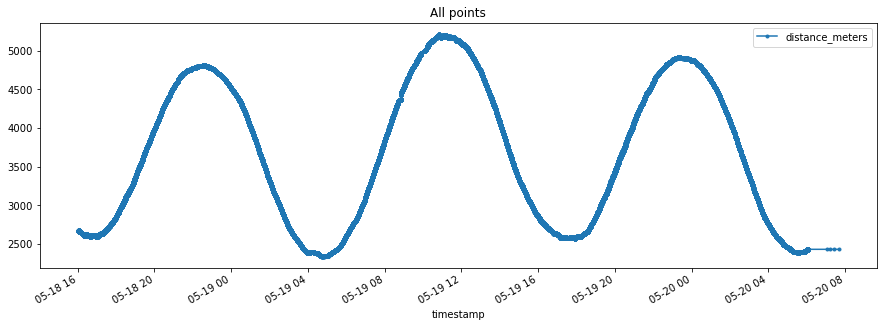

In [44]:
subset.plot(y='distance_meters', style='.-',figsize=(15, 5), use_index=True,title="All points")
num_rows = len(subset.index)
rows_per_sec=6
approx_hours=num_rows/rows_per_sec/(3600)
print(approx_hours)

## Filter Distance Samples via 30 second mean

2065


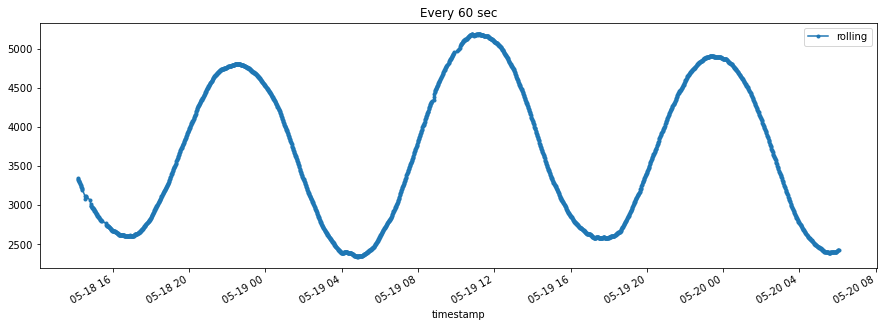

In [108]:
#convert the timestamp to our timezone
df=df.tz_convert('US/Eastern')

#create an index for the date range we'd like
c0 = df.index.to_series().between('2021-5-18 14:00', '2021-5-21')
# c0 = df.index.to_series().between('2021-5-18 21:30', '2021-5-18 23:30')

#create a new dataframe using this index
subset=df[c0]
# df["rolling"] = subset["distance_meters"].rolling('120s').mean()
df["rolling"] = subset["distance_meters"].rolling(120*6, center=True).mean()
n_skip = 6 * 60 * 1 # every 60 seconds, if data was sent 6x / sec
# reapply timeframe subset
subset = df[c0]
subset = subset.iloc[::n_skip, :]

subset.plot(y='rolling', style='.-',figsize=(15, 5), use_index=True,title="Every 60 sec")
print(subset['distance_meters'].size)


In [110]:
subset.to_csv('tide_data_averaged_120s_resampled_60s.csv',date_format='%Y-%m-%d %H:%M:%S')